In [2]:

import os
import shutil 
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import save_model, load_model, Model
from tensorflow.keras.layers import Input, InputLayer, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D
from sklearn.metrics import classification_report
#from keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import imutils
from keras.models import Sequential
import cv2 as cv2
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

2022-08-19 08:47:08.235152: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-19 08:47:08.242904: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-19 08:47:08.242937: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
data_co = {}
main_path = '/home/noor/Documents/new/data/'
for path in os.listdir(main_path):
  for img in os.listdir(f'{main_path}{path}'):
    data_co[img] = path
    shutil.move(f'{main_path}{path}/{img}', main_path)

In [4]:
!rm -d '/home/noor/Documents/new/data/glioma'
!rm -d '/home/noor/Documents/new/data/meningioma'
!rm -d '/home/noor/Documents/new/data/notumor'
!rm -d '/home/noor/Documents/new/data/pituitary'

In [5]:
x = pd.DataFrame(data_co.items(), columns = ['image_id', 'class'])
x['class'].value_counts()

notumor       2000
pituitary     1757
meningioma    1645
glioma        1624
Name: class, dtype: int64

In [6]:
def crop_margins(path):
  img = imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  _,binary = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)

  # find contours from thresholded image
  contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  items = cv2.findContours(binary.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contours = imutils.grab_contours(items)
  c = max(contours, key =cv2.contourArea)
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])
  ADD_PIXELS = 0 
  new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS,extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
  
  # image resizing
  IMG_SIZE = 224
  new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
  return new_img


In [7]:
save_path = '/home/noor/Documents/new/dataset'
in_path = os.path.join('/home/noor/Documents/new/data/')

if not os.path.isdir(save_path):
  os.makedirs(save_path)

for img in os.listdir(in_path):
  imsave(f'{save_path}/{img}', crop_margins(f'{in_path}/{img}'))

In [8]:
subfiles = ['/testing/glioma/' , '/testing/meningioma/' , '/testing/notumor/' ,
'/testing/pituitary/','/training/glioma/' , '/training/meningioma/' , '/training/notumor/' , '/training/pituitary/', '/validation/glioma/',
'/validation/meningioma/', '/validation/notumor/', '/validation/pituitary/']

for path in subfiles:
  if not os.path.isdir(f'{save_path}/{path}'):
    os.makedirs(f'{save_path}/{path}')

In [9]:
x.head()

,image_id,class
0,Tr-me_0274.jpg,meningioma
1,Tr-me_0858.jpg,meningioma
2,Tr-me_1037.jpg,meningioma
3,Tr-me_0821.jpg,meningioma
4,Tr-me_0308.jpg,meningioma


In [10]:
# training and testing set --> setting aside 20% of test , 80% of train 

x_train, x_test, y_train, y_test = train_test_split(x[['image_id']].values, x[['class']].values, test_size = 0.2, random_state = 8)

# using same function above to split the validation set (0.25*0.8=0.2)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.25, random_state=8)

In [11]:
training = x_train.flatten().tolist()
validation = x_val.flatten().tolist()
testing = x_test.flatten().tolist()

x.loc[x['image_id'].isin(training)].to_csv('training.csv', index=False, encoding='utf-8-sig')
x.loc[x['image_id'].isin(validation)].to_csv('validation.csv', index=False, encoding='utf-8-sig')
x.loc[x['image_id'].isin(testing)].to_csv('testing.csv', index=False, encoding='utf-8-sig')


In [12]:
testing = pd.read_csv('./testing.csv')
validation = pd.read_csv('./validation.csv')
training = pd.read_csv('./training.csv')

In [13]:
import shutil
main_path = '/home/noor/Documents/new/dataset'
for indx, row in training.iterrows():
    shutil.move(f"{main_path}/{row['image_id']}",f"{main_path}/training/{row['class']}/{row['image_id']}")

for indx, row in validation.iterrows():
    shutil.move(f"{main_path}/{row['image_id']}",f"{main_path}/validation/{row['class']}/{row['image_id']}")


for indx,row in testing.iterrows():
    shutil.move(f"{main_path}/{row['image_id']}",f"{main_path}/testing/{row['class']}/{row['image_id']}") 

In [14]:
train_data = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.2,
                                    rotation_range=2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True)

training_set = train_data.flow_from_directory(directory="/home/noor/Documents/new/dataset/training",
                                                  target_size=(224,224),
                                                  class_mode='categorical',
                                                  batch_size=32)

Found 4215 images belonging to 4 classes.


In [15]:
validation_data = ImageDataGenerator(rescale=1./255)

validation_set = validation_data.flow_from_directory(directory="/home/noor/Documents/new/dataset/validation",
                                                        target_size=(224,224),
                                                        class_mode='categorical',
                                                        batch_size=32,
                                                        shuffle = False)

Found 1405 images belonging to 4 classes.


In [16]:
test_set = validation_data.flow_from_directory(directory="/home/noor/Documents/sample/dataset/testing",
                                                        target_size=(224,224),
                                                        class_mode='categorical',
                                                        batch_size=1,
                                                        shuffle = False)

Found 1406 images belonging to 4 classes.


In [16]:
model5 = Sequential()

# Convolutional layer 1
model5.add(Conv2D(64,(7,7), input_shape=(224, 224, 3), padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))

#Convolutional layer 2
model5.add(Conv2D(128,(7,7), padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 3
model5.add(Conv2D(128,(7,7), padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 4
model5.add(Conv2D(256,(7,7), padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))

 # Convolutional layer 5
model5.add(Conv2D(256,(7,7), padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 6
model5.add(Conv2D(512,(7,7), padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))

model5.add(Flatten())

# Full connect layers

model5.add(Dense(units= 1024, activation='relu'))
model5.add(Dropout(0.25))
model5.add(Dense(units=512, activation='relu'))
model5.add(Dropout(0.25))
model5.add(Dense(units=4, activation='softmax'))



model5.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy',
                   metrics= ['categorical_accuracy'])

2022-08-17 14:24:06.585279: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/noor/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-08-17 14:24:06.585321: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-17 14:24:06.585349: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (noor): /proc/driver/nvidia/version does not exist
2022-08-17 14:24:06.585819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
model5_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model5_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model5_mcp = ModelCheckpoint(filepath = 'model5_weights.h5', monitor = 'val_categorical_accuracy', 
                      save_best_only = True, verbose = 1)

history5 = model5.fit(training_set, steps_per_epoch=4215//32, epochs=100, validation_data=validation_set, validation_steps= 1405//32,
                     callbacks=[model5_es, model5_rlr, model5_mcp])

Epoch 1/100
131/131 [==============================] - ETA: 0s - loss: 1.1345 - categorical_accuracy: 0.5694 
Epoch 1: val_categorical_accuracy improved from -inf to 0.23619, saving model to model5_weights.h5
131/131 [==============================] - 1890s 14s/step - loss: 1.1345 - categorical_accuracy: 0.5694 - val_loss: 1.4622 - val_categorical_accuracy: 0.2362 - lr: 0.0010
Epoch 2/100
131/131 [==============================] - ETA: 0s - loss: 0.7749 - categorical_accuracy: 0.6981 
Epoch 2: val_categorical_accuracy improved from 0.23619 to 0.44477, saving model to model5_weights.h5
131/131 [==============================] - 1858s 14s/step - loss: 0.7749 - categorical_accuracy: 0.6981 - val_loss: 1.2901 - val_categorical_accuracy: 0.4448 - lr: 0.0010
Epoch 3/100
131/131 [==============================] - ETA: 0s - loss: 0.6549 - categorical_accuracy: 0.7437 
Epoch 3: val_categorical_accuracy improved from 0.44477 to 0.56977, saving model to model5_weights.h5
131/131 [================

In [18]:
model5.evaluate(test_set)

1406/1406 [==============================] - 309s 220ms/step - loss: 0.1012 - categorical_accuracy: 0.9666


[0.10117150098085403, 0.9665718078613281]

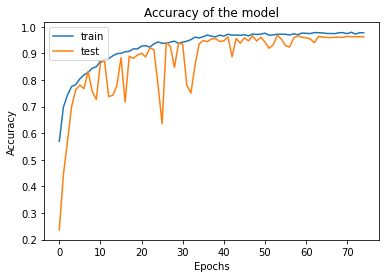

In [20]:
# comparing the training and testing accuracy
plt.plot(history5.history['categorical_accuracy'])
plt.plot(history5.history['val_categorical_accuracy'])
plt.title('Accuracy of the model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','test'],loc='upper left')
plt.show()

In [17]:
def plot_confusion_matrix(true_lab,predict_lab,classes,path):
  matrix_confusion = tf.math.confusion_matrix(labels=true_lab, predictions=predicted_lab, num_classes=len(classes))
  ax = plt.subplot()
  sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.savefig(f'{path}confusion_matrix.png')

In [18]:
def dump_text(text,path):
  text_file = open(path, "w")
  text_file.write(text)
  text_file.close()

In [19]:
savepath = '/home/noor/Documents/new/'

1406/1406 [==============================] - 311s 221ms/step
              precision    recall  f1-score   support

      glioma       0.97      0.96      0.96       294
  meningioma       0.96      0.93      0.95       358
     notumor       0.98      0.99      0.99       397
   pituitary       0.96      0.98      0.97       357

    accuracy                           0.97      1406
   macro avg       0.97      0.97      0.97      1406
weighted avg       0.97      0.97      0.97      1406



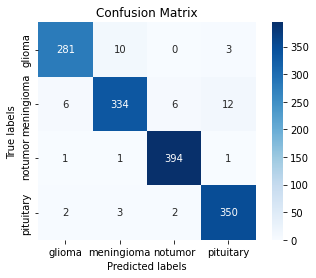

In [24]:
p = model5.predict(test_set)
predicted_lab = p.argmax(axis=-1)
true_lab = test_set.classes
plot_confusion_matrix(true_lab, predicted_lab, test_set.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=test_set.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')

In [24]:
model6 = Sequential()

# Convolutional layer 1
model6.add(Conv2D(64,(7,7), input_shape=(224, 224, 3), padding='same', activation='relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling2D(pool_size=(2,2)))

#Convolutional layer 2
model6.add(Conv2D(128,(7,7), padding='same', activation='relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 3
model6.add(Conv2D(128,(7,7), padding='same', activation='relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 4
model6.add(Conv2D(256,(7,7), padding='same', activation='relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling2D(pool_size=(2,2)))

 # Convolutional layer 5
model6.add(Conv2D(256,(7,7), padding='same', activation='relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 6
model6.add(Conv2D(512,(7,7), padding='same', activation='relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling2D(pool_size=(2,2)))

model6.add(Flatten())

# Full connect layers

model6.add(Dense(units= 1024, activation='relu'))
model6.add(Dropout(0.25))
model6.add(Dense(units=1024, activation='relu'))
model6.add(Dropout(0.25))
model6.add(Dense(units=512, activation='relu'))
model6.add(Dropout(0.2))
model6.add(Dense(units=4, activation='softmax'))



model6.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',
                   metrics= ['categorical_accuracy'])

In [25]:
model6_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model6_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model6_mcp = ModelCheckpoint(filepath = 'model6_weights.h5', monitor = 'val_categorical_accuracy', 
                      save_best_only = True, verbose = 1)

history6 = model6.fit(training_set, steps_per_epoch=4215//32, epochs=100, validation_data=validation_set, validation_steps= 1405//32,
                     callbacks=[model6_es, model6_rlr, model6_mcp])

Epoch 1/100
131/131 [==============================] - ETA: 0s - loss: 1.7053 - categorical_accuracy: 0.4552 